In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import fbeta_score

import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] # 修改中文字體
plt.rcParams['axes.unicode_minus'] = False # 顯示負號

# set device to gpu
device = (
"cuda"
if torch.cuda.is_available()
else "mps"
if torch.backends.mps.is_available()
else "cpu"
)
device

'mps'

In [2]:
tfidf_train_data = pd.read_csv('../Data/TrainingData/tfidf_train.csv')
tfidf_val_data = pd.read_csv('../Data/ValidateData/tfidf_val.csv')
word2vec_train_data = pd.read_csv('../Data/TrainingData/word2vec_train.csv')
word2vec_val_data = pd.read_csv('../Data/ValidateData/word2vec_val.csv')
bert_train_data = pd.read_csv('../Data/TrainingData/bert_train.csv')
bert_val_data = pd.read_csv('../Data/ValidateData/bert_val.csv')

In [3]:
def train_mlp_model(df, model_path, scaler_path):
    data = df.copy()
    y = data.pop('source')  # 假设标签列名为 'source'

    # 标准化数据
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data.values)
    # 保存标准化器
    joblib.dump(scaler, scaler_path)

    # 分割数据集
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # 将数据转换为 PyTorch 张量并移动到 GPU
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to(device)

    # 建立 MLP 模型
    input_size = X_train_tensor.shape[1]
    model = nn.Sequential(
        nn.Linear(input_size, 1024),
        nn.ReLU(),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 1),
        nn.Sigmoid()
    ).to(device)

    # 定义损失函数和优化器
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 训练模型
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    # 测试模型并计算混淆矩阵
    model.eval()
    with torch.no_grad():
        y_pred_train = model(X_train_tensor).cpu().numpy()
        y_pred_test = model(X_test_tensor).cpu().numpy()

        y_pred_train = (y_pred_train > 0.5).astype(int)
        y_pred_test = (y_pred_test > 0.5).astype(int)

        y_train_numpy = y_train_tensor.cpu().numpy()
        y_test_numpy = y_test_tensor.cpu().numpy()

        cm_train = confusion_matrix(y_train_numpy, y_pred_train)
        cm_test = confusion_matrix(y_test_numpy, y_pred_test)

    # 绘制混淆矩阵
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    sns.heatmap(cm_train, annot=True, fmt='d', ax=ax[0], cmap='Blues')
    ax[0].set_title('Train Confusion Matrix')
    ax[0].set_xlabel('Predicted')
    ax[0].set_ylabel('Actual')

    sns.heatmap(cm_test, annot=True, fmt='d', ax=ax[1], cmap='Blues')
    ax[1].set_title('Test Confusion Matrix')
    ax[1].set_xlabel('Predicted')
    ax[1].set_ylabel('Actual')

    plt.show()

    # 保存整个模型
    torch.save(model, model_path)
    return model, scaler

In [4]:
def evaluate_on_new_data(model, scaler, new_data):
    data = new_data.copy()
    y_new = data.pop('source')  # 假设标签列名为 'source'
    X_new_scaled = scaler.transform(data.values)

    # 将数据转换为 PyTorch 张量并移动到 GPU
    X_new_tensor = torch.tensor(X_new_scaled, dtype=torch.float32).to(device)
    y_new_tensor = torch.tensor(y_new.values, dtype=torch.float32).view(-1, 1).to(device)

    # 测试模型并计算 F2 Score 和混淆矩阵
    model.eval()
    with torch.no_grad():
        y_pred_new = model(X_new_tensor).cpu().numpy()
        y_pred_new = (y_pred_new > 0.5).astype(int)
        y_new_numpy = y_new_tensor.cpu().numpy()

        new_f2 = fbeta_score(y_new_numpy, y_pred_new, beta=2)
        cm_new = confusion_matrix(y_new_numpy, y_pred_new)

    print(f'New Data F2 Score: {new_f2:.4f}')

    # 绘制混淆矩阵
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_new, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix on New Data')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

/Users/jim/anaconda3/envs/forDeepLearning/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch [10/100], Loss: 0.0487
Epoch [20/100], Loss: 0.0002
Epoch [30/100], Loss: 0.0000
Epoch [40/100], Loss: 0.0000
Epoch [50/100], Loss: 0.0000
Epoch [60/100], Loss: 0.0000
Epoch [70/100], Loss: 0.0000
Epoch [80/100], Loss: 0.0000
Epoch [90/100], Loss: 0.0000
Epoch [100/100], Loss: 0.0000


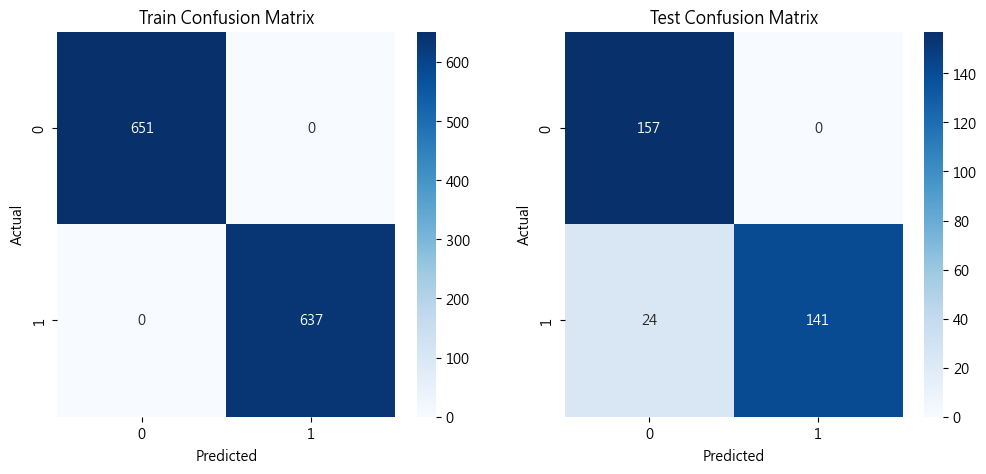

New Data F2 Score: 0.9794


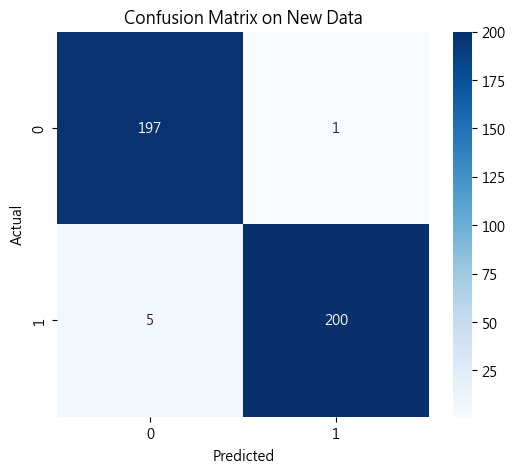

In [5]:
model, scaler = train_mlp_model(tfidf_train_data, '../Data/Model/tfidf_mlp_model.pth', '../Data/Model/tfidf_scaler.pkl')
evaluate_on_new_data(model, scaler, tfidf_val_data)

Epoch [10/100], Loss: 0.0898
Epoch [20/100], Loss: 0.0203
Epoch [30/100], Loss: 0.0026
Epoch [40/100], Loss: 0.0005
Epoch [50/100], Loss: 0.0001
Epoch [60/100], Loss: 0.0001
Epoch [70/100], Loss: 0.0000
Epoch [80/100], Loss: 0.0000
Epoch [90/100], Loss: 0.0000
Epoch [100/100], Loss: 0.0000


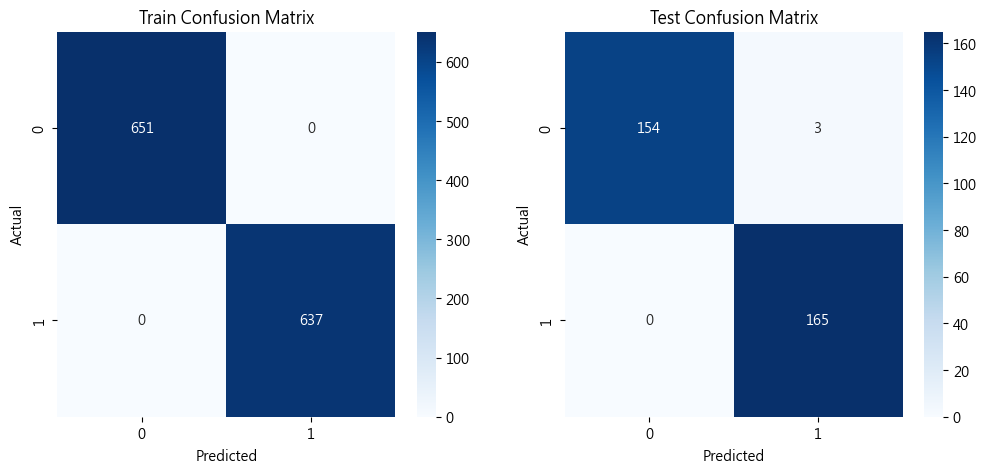

New Data F2 Score: 0.9726


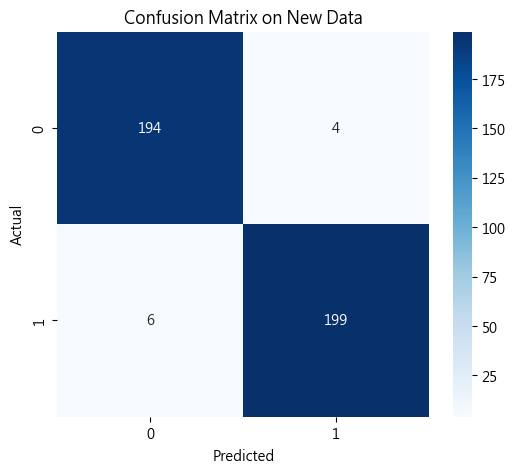

In [6]:
model, scaler = train_mlp_model(word2vec_train_data, '../Data/Model/word2vec_mlp_model.pth', '../Data/Model/word2vec_scaler.pkl')
evaluate_on_new_data(model, scaler, word2vec_val_data)

Epoch [10/100], Loss: 0.0028
Epoch [20/100], Loss: 0.0000
Epoch [30/100], Loss: 0.0000
Epoch [40/100], Loss: 0.0000
Epoch [50/100], Loss: 0.0000
Epoch [60/100], Loss: 0.0000
Epoch [70/100], Loss: 0.0000
Epoch [80/100], Loss: 0.0000
Epoch [90/100], Loss: 0.0000
Epoch [100/100], Loss: 0.0000


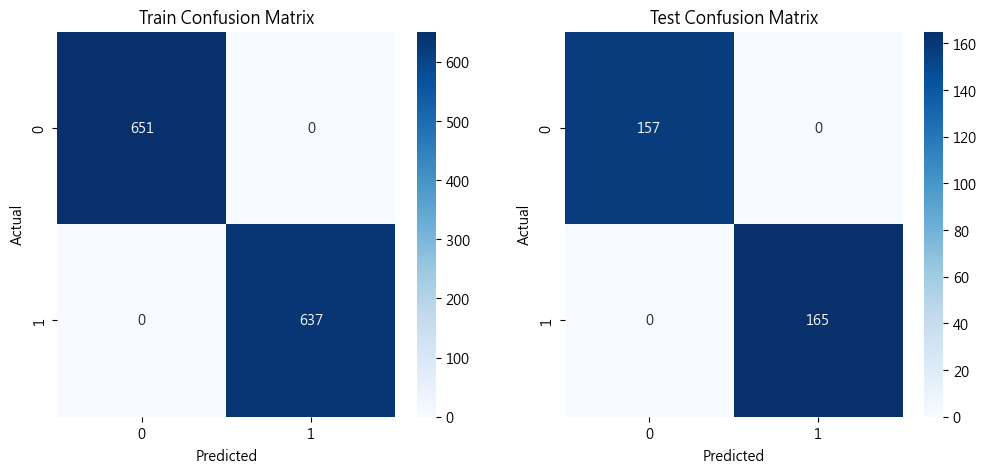

New Data F2 Score: 1.0000


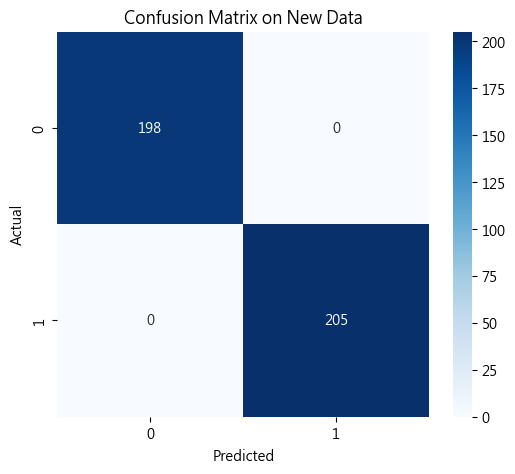

In [7]:
model, scaler = train_mlp_model(bert_train_data, '../Data/Model/bert_mlp_model.pth', '../Data/Model/bert_scaler.pkl')
evaluate_on_new_data(model, scaler, bert_val_data)